## **ANALYSE DU RISQUE DE DEFAUT : CAS DU LOAN CLUB**

### **0. Introduction**

* **Introduction et objectif du projet**

Ce projet a pour objectif de développer un modèle de prédiction du risque de défaut de remboursement (Credit Risk Modeling) pour les demandes de prêt.

L'étude vise à fournir un score de risque individuel (probabilité de défaut) basé sur la modélisation, permettant à l'établissement financier de prendre une décision éclairée (Acceptation/Refus du prêt).

* **Les données**

Les données proviennent de la plateforme de crowdfunding Loan Club et sont contenues dans un fichier CSV. Cet ensemble de données inclut des informations client et le statut final du prêt (remboursé ou en défaut, variable *loan_status*), servant de variable cible pour la modélisation. Nous disposons de 20 000 observations et 26 variables.

* **La méthodologie**

La méthodologie suit un processus structuré, débutant par l'importation et le nettoyage des données, ainsi que la préparation des variables (conversion et encodage). Ensuite, les données sont divisées en ensembles d'entraînement et de test pour l'entraînement d'un modèle de régression logistique. Enfin, la démarche se conclut par l'analyse de la performance (ROC, AUC, matrice de confusion) et la construction d’un score pour la segmentation.


### **1. Importation et inspection des données**

In [390]:
#importation des libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [391]:
#importation de la base de données
df=pd.read_csv("loan_club.csv")

In [392]:
#Nombre d’observations et de variables
df.shape

(20000, 26)

> Les données contiennent 20 000 lignes(observations) et 26 colonnes(variables).

In [393]:
#Types de données
df.dtypes

id                            int64
loan_amnt                     int64
term                         object
int_rate                     object
grade                        object
emp_title                    object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
loan_status                  object
purpose                      object
zip_code                     object
addr_state                   object
dti                         float64
delinq_2yrs                   int64
inq_last_6mths                int64
pub_rec                       int64
acc_now_delinq                int64
avg_cur_bal                 float64
chargeoff_within_12_mths      int64
delinq_amnt                   int64
num_accts_ever_120_pd         int64
num_actv_bc_tl                int64
num_bc_sats                   int64
pub_rec_bankruptcies          int64
dtype: object

 > Cette sortie présente les types de données initiaux des variables. On note la présence de variables numériques (int64, float64) et de nombreuses variables catégorielles (object).

In [394]:
#Valeurs manquantes
df.isnull().sum()

id                             0
loan_amnt                      0
term                           0
int_rate                       0
grade                          0
emp_title                   1325
emp_length                   946
home_ownership                 0
annual_inc                     0
verification_status            0
loan_status                    0
purpose                        0
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
pub_rec                        0
acc_now_delinq                 0
avg_cur_bal                    1
chargeoff_within_12_mths       0
delinq_amnt                    0
num_accts_ever_120_pd          0
num_actv_bc_tl                 0
num_bc_sats                    0
pub_rec_bankruptcies           0
dtype: int64

La quasi-totalité des variables du jeu de données est complète. Toutefois, trois colonnes présentent des valeurs manquantes (NaN) et nécessitent un traitement adapté :

- *emp_title* (1325 NaN) : Le titre de l'emploi est la variable la plus concernée par les valeurs manquantes. En raison de la diversité des intitulés, il sera pertinent d'envisager soit une imputation (par exemple, regroupement ou création d'une catégorie « Inconnu »), soit la suppression de la variable si elle n'apporte pas d'information significative au modèle.

- *emp_length* (946 NaN) : La durée d'emploi est une variable clé pour l'évaluation du risque. Les valeurs manquantes seront remplacées par une modalité spécifique (telle que « Inconnu » ou « Sans emploi ») afin de conserver l'information sans introduire de biais.

- *avg_cur_bal* (1 NaN) : Un seul cas de valeur manquante est observé pour le solde courant moyen. L'observation correspondante sera simplement supprimée, l'impact sur l'analyse étant négligeable.

In [395]:
#Aperçu des premières lignes
df.head(5)

,id,loan_amnt,term,int_rate,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,inq_last_6mths,pub_rec,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,pub_rec_bankruptcies
0,20001,7000,36 months,10.99%,B,BRANCH MANAGER,7 years,MORTGAGE,57000.0,Not Verified,...,1,0,0,8321.0,0,0,0,4,7,0
1,20002,13925,36 months,14.30%,C,Medical biller,< 1 year,RENT,43000.0,Source Verified,...,3,0,0,641.0,0,0,0,5,6,0
2,20003,7000,36 months,10.99%,B,Medical Clerk,7 years,OWN,30000.0,Not Verified,...,0,0,0,837.0,0,0,0,5,6,0
3,20004,9600,36 months,7.90%,A,Bookkeeper,10+ years,MORTGAGE,46000.0,Not Verified,...,0,0,0,14140.0,0,0,0,3,4,0
4,20005,10775,36 months,17.10%,C,Manufacturing Lead,7 years,OWN,75000.0,Source Verified,...,1,0,0,1171.0,0,0,0,1,1,0


### **2. Préparation des données**

Dans cette section, nous allons effectuer un nettoyage approfondi des données, en traitant spécifiquement les colonnes nécessitant une correction ou une transformation. Une attention particulière sera portée au recodage des variables catégorielles afin de garantir la cohérence et la qualité des informations pour la modélisation.

In [396]:
#Nettoyage des valeurs numériques
#TERM
# Extraction des chiffres à gauche de "month" dans les observations de la variable term
df['term'] = df['term'].str.extract(r'(\d+)')
# Affichage du résultat de la transformation
print(df['term'].head(5))

0    36
1    36
2    36
3    36
4    36
Name: term, dtype: object


In [397]:
#INT RATE
# Extraction des chiffres en ignornant le signe % dans la variable "int_rate"
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)
# Affichage du résultat de la transformation
print(df['int_rate'].head(5))

0    10.99
1    14.30
2    10.99
3     7.90
4    17.10
Name: int_rate, dtype: float64


In [398]:
# Encodage des variables catégorielles et détermination des modalités de référence
#EMP LENGTH
# Recodage de la variable emp_length(niveau d'expérience professionnelle)
#Regroupement des nouvelles modalités dans le dictionnaire pour les appliquer après
emp_length_rec = {
    "< 1 year": "jeune_diplome",
    "1 year": "jeune_diplome",
    "2 years": "junior",
    "3 years": "junior",
    "4 years": "junior",
    "5 years": "confirme",
    "6 years": "confirme",
    "7 years": "confirme",
    "8 years": "confirme",
    "9 years": "confirme",
    "10+ years": "senior"
}

# Application des modifications
df['emp_length'] = df['emp_length'].replace(emp_length_rec).fillna('inconnu') 
# les valeurs manquantes seront remplacées par "inconnu"

# Affichage des catégories
df['emp_length'].unique()

array(['confirme', 'jeune_diplome', 'senior', 'inconnu', 'junior'],
      dtype=object)

In [399]:
# #VERIFICATION STATUS
# verification_status_rec = {
#     "Not Verified": "Not Verified",
#     "Source Verified": "Verified",
#     "Verified": "Verified"
# }

# # Application des modifications
# df['verification_status'] = df['verification_status'].replace(verification_status_rec)

# #Affichage des modalités
# df['verification_status'].unique()

In [400]:
#HOME OWNSHIP
home_ownership_rec = {
    "RENT": "locataire",
    "OWN": "proprietaire",
    "MORTGAGE": "hypotheque"
}

# Application des modifications
df['home_ownership'] = df['home_ownership'].replace(home_ownership_rec)

#Affichage des modalités
df['home_ownership'].unique()

array(['hypotheque', 'locataire', 'proprietaire'], dtype=object)

In [401]:
#LOAN STATUS
loan_status_rec = {
    "Charged Off": 1,
    "Fully Paid": 0
    }

pd.set_option('future.no_silent_downcasting', True)
# Application des modifications
df['loan_status'] = df['loan_status'].replace(loan_status_rec).astype('int64')

In [402]:
#PURPOSE
purpose_rec = { "car": "depenses_divers",
    "credit_card": "carte_credit",
    "debt_consolidation": "consolidation_dette",
    "home_improvement": "habitat",
    "house": "habitat",
    "major_purchase": "depenses_divers",
    "medical": "depenses_divers",
    "moving": "habitat",
    "other": "depenses_divers",
    "renewable_energy": "habitat",
    "small_business": "petit_commerce",
    "vacation": "depenses_divers",
    "wedding": "depenses_divers"}


# Application des modifications
df['purpose'] = df['purpose'].replace(purpose_rec)

# Affichage des modalités
df['purpose'].unique()

array(['consolidation_dette', 'carte_credit', 'habitat',
       'depenses_divers', 'petit_commerce'], dtype=object)

In [403]:
# Vérification du type de variables après transformation
df.dtypes

id                            int64
loan_amnt                     int64
term                         object
int_rate                    float64
grade                        object
emp_title                    object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
loan_status                   int64
purpose                      object
zip_code                     object
addr_state                   object
dti                         float64
delinq_2yrs                   int64
inq_last_6mths                int64
pub_rec                       int64
acc_now_delinq                int64
avg_cur_bal                 float64
chargeoff_within_12_mths      int64
delinq_amnt                   int64
num_accts_ever_120_pd         int64
num_actv_bc_tl                int64
num_bc_sats                   int64
pub_rec_bankruptcies          int64
dtype: object

In [404]:
# Affichage des valeurs manquantes
df.isnull().sum()

id                             0
loan_amnt                      0
term                           0
int_rate                       0
grade                          0
emp_title                   1325
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
loan_status                    0
purpose                        0
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
pub_rec                        0
acc_now_delinq                 0
avg_cur_bal                    1
chargeoff_within_12_mths       0
delinq_amnt                    0
num_accts_ever_120_pd          0
num_actv_bc_tl                 0
num_bc_sats                    0
pub_rec_bankruptcies           0
dtype: int64

##### **Gestion des valeurs manquantes**

- La variable *emp_title*, jugée peu pertinente pour l’analyse, sera supprimée afin de simplifier le jeu de données.

- Concernant *avg_cur_bal*, une seule observation présente une valeur manquante ; cette ligne sera retirée sans impact significatif sur l’analyse.

In [405]:
# Suppression de la variable "emp_title"
del df['emp_title']
#df['emp_title'] = df['emp_title'].fillna('inconnu')
# Suppression de la ligne où la variable "avg_cur_bal" est vide
df = df[df['avg_cur_bal'].notna()]

# Vérification l'effectif des valeurs manquantes 
df.isnull().sum()

id                          0
loan_amnt                   0
term                        0
int_rate                    0
grade                       0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
zip_code                    0
addr_state                  0
dti                         0
delinq_2yrs                 0
inq_last_6mths              0
pub_rec                     0
acc_now_delinq              0
avg_cur_bal                 0
chargeoff_within_12_mths    0
delinq_amnt                 0
num_accts_ever_120_pd       0
num_actv_bc_tl              0
num_bc_sats                 0
pub_rec_bankruptcies        0
dtype: int64

### **3. Analyse exploratoire**

#### **3.1. Statistiques descriptives**

La sortie ci-dessous présente les principales statistiques descriptives (moyenne, écart-type, min, max, quartiles) pour chaque variable numérique du jeu de données. Cela permet d'obtenir une vue d'ensemble sur la distribution, la dispersion et les éventuelles valeurs extrêmes (outliers) des variables, facilitant ainsi la détection d'anomalies ou de besoins de transformation avant la modélisation.

In [406]:
df.describe().round(2)

,id,loan_amnt,int_rate,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,pub_rec_bankruptcies
count,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.00,19999.0,19999.00,19999.00,19999.00,19999.00
mean,30000.95,14628.63,14.44,72772.18,0.16,17.41,0.30,0.78,0.14,0.01,13848.14,0.01,12.8,0.36,3.73,4.60,0.11
std,5773.44,8064.36,4.58,45999.62,0.36,7.53,0.79,1.03,0.55,0.08,15456.79,0.09,690.3,1.01,2.02,2.42,0.33
min,20001.00,1000.00,6.00,9204.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
25%,25001.50,8500.00,10.99,46000.00,0.00,11.70,0.00,0.00,0.00,0.00,3168.50,0.00,0.0,0.00,2.00,3.00,0.00
50%,30001.00,13000.00,14.30,64000.00,0.00,17.10,0.00,0.00,0.00,0.00,8223.00,0.00,0.0,0.00,3.00,4.00,0.00
75%,35000.50,20000.00,17.76,87500.00,0.00,22.94,0.00,1.00,0.00,0.00,19759.50,0.00,0.0,0.00,5.00,6.00,0.00
max,40000.00,35000.00,26.06,2000000.00,1.00,34.99,18.00,6.00,49.00,5.00,218986.00,3.00,53760.0,19.00,21.00,25.00,8.00


**1. Variables clés de solvabilité et endettement**

- *loan_status* (Variable cible) : La moyenne est de 0.16, indiquant que le taux de défaut est d'environ 16% dans l'échantillon. La classe est déséquilibrée (84% de prêts remboursés), un point à considérer pour la modélisation (techniques de rééchantillonnage ou ajustement des poids de classe).

- *annual_inc* (Revenu annuel) : Le revenu annuel moyen est de 72 772. L'écart-type très élevé (45 999) et la valeur maximale de 2 000 000 indiquent la présence de valeurs aberrantes (outliers) extrêmes dans le haut de la distribution.

- *dti* (Debt-to-Income) : Le ratio moyen est de 17.41. Le maximum de 34.99 est très proche du seuil maximal de 35-40% souvent utilisé dans le secteur, mais semble plausible pour des cas extrêmes. Sa distribution inter-quartile (11.70 à 22.94)

**2. Caractéristiques du prêt**

- *loan_amnt* (Montant du prêt) : Le montant moyen est de 14 628. L'étendue va de 1 000 € à 35 000. La distribution est assez large (écart-type de 8 064), mais les quartiles montrent une concentration des prêts entre 8 500 et 20 000.

- *int_rate* (Taux d'intérêt) : Le taux moyen est de 14.44% avec une dispersion modérée (écart-type 4.58). La fourchette de 6.00% à 26.06% reflète bien le spectre de risque, généralement les taux les plus élevés étant associés aux emprunteurs les plus risqués.

**3. Indicateurs de risque passé (Historique de crédit)**

Les variables liées aux défauts passés (*delinq_2yrs, pub_rec, chargeoff_within_12_mths, num_accts_ever_120_pd, acc_now_delinq*) présentent des moyennes très faibles (proches de zéro).

Par exemple, *delinq_2yrs* a une moyenne de 0.3, et *pub_rec_bankruptcies* une moyenne de 0.14. Ceci indique que la majorité des emprunteurs n'ont aucun incident de crédit récent ou historique.

Cependant, les valeurs maximales (ex: *delinq_2yrs* à 18, *pub_rec* à 49, *delinq_amnt* à 53 760) confirment l'existence de quelques cas d'emprunteurs avec un historique de crédit très sévèrement dégradé.

#### **3.2. Visualisation de la variable cible (loan_status)**

La variable *loan_status* est binaire : elle indique si le prêt a été remboursé ou est en défaut.

In [407]:
status_counts = df['loan_status'].value_counts()
status_pourcentages = df['loan_status'].value_counts(normalize=True) * 100

# Créer un tableau récapitulatif
status_recap = pd.DataFrame({
    'Effectif': status_counts,
    'Pourcentage': status_pourcentages.round(2)}
)

print("==== Analyse de Fréquence de la variable cible (loan_status) ====")
print(status_recap)

==== Analyse de Fréquence de la variable cible (loan_status) ====
             Effectif  Pourcentage
loan_status                       
0               16871        84.36
1                3128        15.64


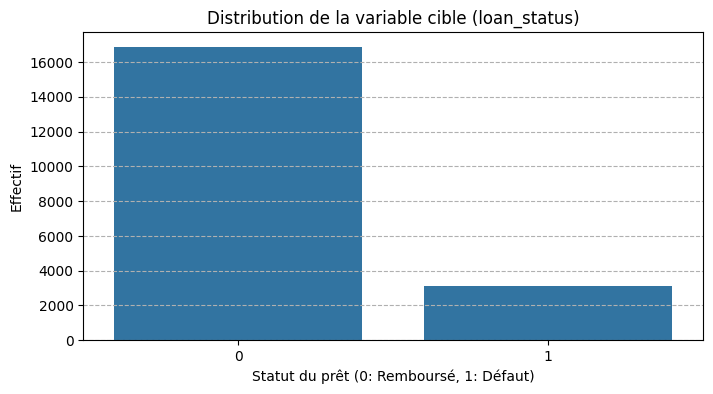

In [408]:
plt.figure(figsize=(8, 4))
sns.countplot(x='loan_status', data=df, order=df['loan_status'].value_counts().index)
plt.title('Distribution de la variable cible (loan_status)')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Effectif')
plt.grid(axis='y', linestyle='--')
plt.show()

Les données sont fortement déséquilibrées (84% de Remboursé vs 16% de Defaut).

*Impact sur la modélisation* : Ce déséquilibre est une préoccupation majeure. Si le modèle prédit toujours la classe majoritaire (Remboursé), il atteindra une précision de 86%, ce qui est trompeur.

#### **3.3. Visualisation du taux d'intérêt**

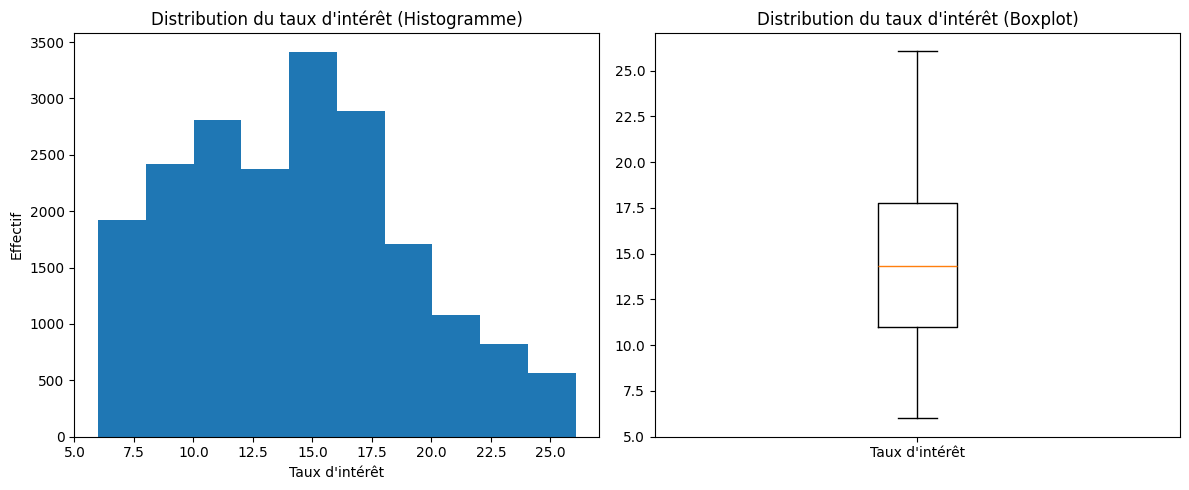

In [409]:
# Création de la figure (fig) et des deux sous-graphiques (axes)
# (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogramme 
axes[0].hist(df["int_rate"])
axes[0].set_title("Distribution du taux d'intérêt (Histogramme)" )
axes[0].set_xlabel("Taux d'intérêt")
axes[0].set_ylabel("Effectif")

# 2. Boxplot
axes[1].boxplot(df["int_rate"])
axes[1].set_title("Distribution du taux d'intérêt (Boxplot)")
axes[1].set_xticklabels(["Taux d'intérêt"]) # Nomme l'axe des x pour le boxplot

# Ajustement de l'espace entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()

* **Mode et Médiane** : L'histogramme montre une forte concentration des prêts dans la classe 12.5% à 15%, qui représente le taux modal. Le boxplot confirme une médiane autour de 14.5%.

* **Implication opérationnelle** : La majorité des clients de la base de données se situe dans la catégorie de risque moyen-élevé. C'est sur cette plage que notre modèle devra être le plus précis.

* 50% des observations se trouvent entre 11% (Q1) et 17.8% (Q3). L'absence de points isolés sur le boxplot et la continuité de la distribution sur l'histogramme (de 6% à 26%) confirment que la variable est robuste. Aucun traitement d'outlier n'est nécessaire pour cette variable.

#### **3.4. Durée du prêt**

Ici, il est question de calculer la répartition des prêts entre les différentes durées.

In [410]:
# Compter les occurrences de chaque catégorie
term_counts = df['term'].value_counts()

# Calculer les pourcentages
term_pourcentages = df['term'].value_counts(normalize=True) * 100

# Créer un tableau récapitulatif
term_recap = pd.DataFrame({
    'Effectif': term_counts,
    'Pourcentage': term_pourcentages.round(2)}
)

print("==== Analyse de fréquence de la durée du prêt 'term' ====")
print(term_recap)

==== Analyse de fréquence de la durée du prêt 'term' ====
      Effectif  Pourcentage
term                       
36       14459         72.3
60        5540         27.7


La visualisation permet de confirmer rapidement l'équilibre ou le déséquilibre entre les durées de prêt.

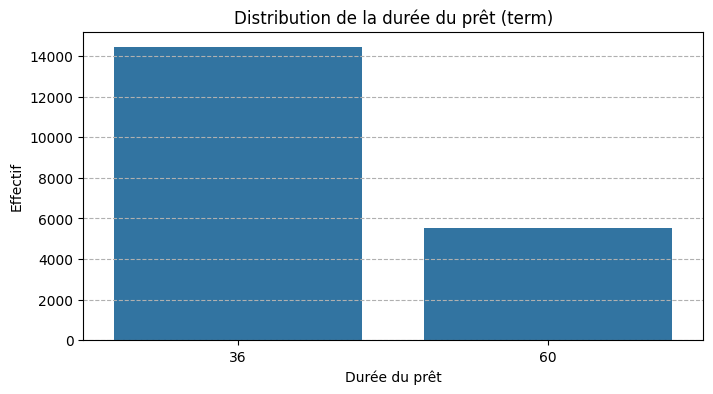

In [411]:
plt.figure(figsize=(8, 4))
sns.countplot(x='term', data=df, order=df['term'].value_counts().index)

plt.title('Distribution de la durée du prêt (term)')
plt.xlabel('Durée du prêt')
plt.ylabel('Effectif')
plt.grid(axis='y', linestyle='--')
plt.show()

Le tableau de fréquences et le graphique à barres révèlent une répartition claire des durées des prêts.
La grande majorité des prêts ont une durée courte de 36 mois, représentant 72.3% de l'échantillon (14 459 observations) tandis que les prêts d'une durée plus longue de 60 mois représentent une part de 27.7% de l'échantillon (5 540 observations).

Les prêts à 36 mois sont généralement considéré comme un profil de risque plus faible car l'exposition au défaut est réduite dans le temps. Néanmoins, près d'un tiers du portefeuille (27.7%) est constitué de prêts à 60 mois. Ces prêts sont intrinsèquement plus risqués (le risque d'événements financiers négatifs augmentant avec la durée).

#### **3.5. Analyse bivariée**

#### **3.5.1. Montant du prêt et le statut de défaut**

L'analyse bivariée entre le montant du prêt (*loan_amnt*) et le statut de défaut (*loan_status*) permet d'évaluer si les montants de prêts sont significativement plus élevés pour les clients en défaut. On va nous servir du Test T de Student qui permet de voir si les moyennes des deux groupes sont statistiquement différentes.

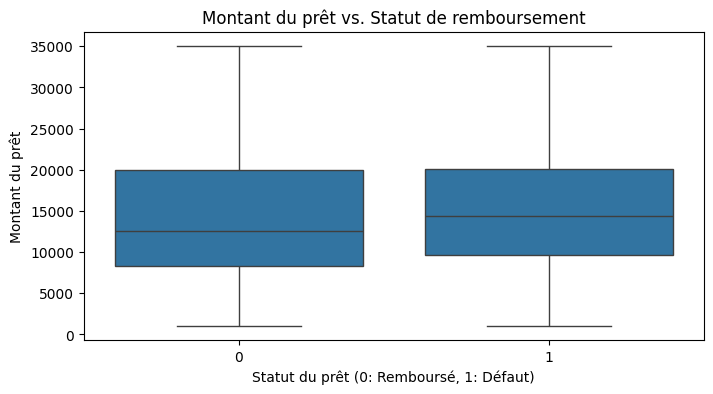

n==== Test T de Student pour loan_amnt ====
Statistique T : -6.48
P-value : 0.00000


In [412]:
from scipy.stats import ttest_ind

# Analyse graphique : Boxplots
plt.figure(figsize=(8, 4))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title('Montant du prêt vs. Statut de remboursement')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Montant du prêt')
plt.show()

# Test Statistique : Test T de Student
# Filtrer les montants par statut
rembourses = df[df['loan_status'] == 0]['loan_amnt'].dropna()
defaut = df[df['loan_status'] == 1]['loan_amnt'].dropna()

# Le Test T de Student permet de voir si les moyennes des deux groupes sont statistiquement différentes
statistic, p_value = ttest_ind(rembourses, defaut, equal_var=False)

print(f"n==== Test T de Student pour loan_amnt ====")
print(f"Statistique T : {statistic:.2f}")
print(f"P-value : {p_value:.5f}")

**Interprétation :** 

* La médiane du montant du prêt est légèrement plus élevée pour le groupe Défaut (1) que pour le groupe Remboursé (0).La fourchette inter-quartile (Q1 à Q3) pour les défauts se situe aussi légèrement plus haut, indiquant que le cœur des prêts en défaut tend à être d'un montant supérieur aux prêts remboursés. L'étendue totale (des moustaches) est la même, s'étendant du minimum (1 000) au maximum (35 000), ce qui est attendu.

* La p-value est largement inférieure au seuil de signification standard $\alpha$ = 0.05. Nous rejetons l'hypothèse nulle (H0), ce qui signifie qu'il existe une différence statistiquement très significative entre le montant moyen du prêt accordé aux emprunteurs qui ont remboursé et ceux qui ont fait défaut.

* Conclusion : Un montant de prêt plus élevé représente une charge de dette plus lourde qui augmente la sensibilité de l'emprunteur aux chocs financiers et, par conséquent, son risque de défaut.

#### **3.5.2. Ratio dti et le statut de défaut**

Le ratio Dette/Revenu est un indicateur de solvabilité critique.

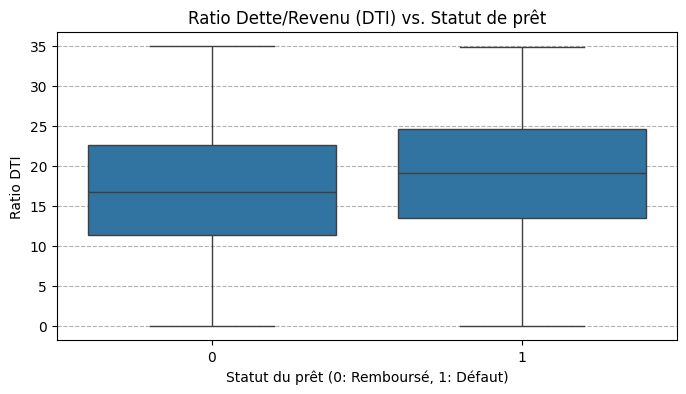

n==== Test T de Student pour DTI ====
DTI moyen des Remboursés (0) : 17.11
DTI moyen des Défauts (1) : 19.03
-----------------------------------
Statistique T : -13.26
P-value : 0.00000


In [413]:
# Visualisation : Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='loan_status', y='dti', data=df)
plt.title('Ratio Dette/Revenu (DTI) vs. Statut de prêt')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Ratio DTI')
plt.grid(axis='y', linestyle='--')
plt.show() # 

# Test Statistique : Test T de Student
rembourses_dti = df[df['loan_status'] == 0]['dti'].dropna()
defaut_dti = df[df['loan_status'] == 1]['dti'].dropna()

statistic_dti, p_value_dti = ttest_ind(rembourses_dti, defaut_dti, equal_var=False)

print(f"n==== Test T de Student pour DTI ====")
print(f"DTI moyen des Remboursés (0) : {rembourses_dti.mean():.2f}")
print(f"DTI moyen des Défauts (1) : {defaut_dti.mean():.2f}")
print("-" * 35)
print(f"Statistique T : {statistic_dti:.2f}")
print(f"P-value : {p_value_dti:.5f}")

**Interprétation :**

- Si le DTI moyen des Défauts est plus élevé, cela confirme que le dti est un excellent prédicteur de défaut, car une dette plus lourde par rapport au revenu augmente le risque.

- La p-value est très faible (0.000), on conclue que le *dti* est significativement différent entre les deux groupes. 

##### **3.5.3. Revenu annuel et le statut du prêt**

Le revenu annuel est l'indicateur de capacité de remboursement. Cette variable ayant des valeurs aberrantes (outliers), il sera préférable de se baser sur la médiane plutôt que la moyenne. En effet, la moyenne est plus sensible aux valeurs extremes. On utilisera également le Test de Mann-Whitney U (équivalent non paramétrique du Test T).

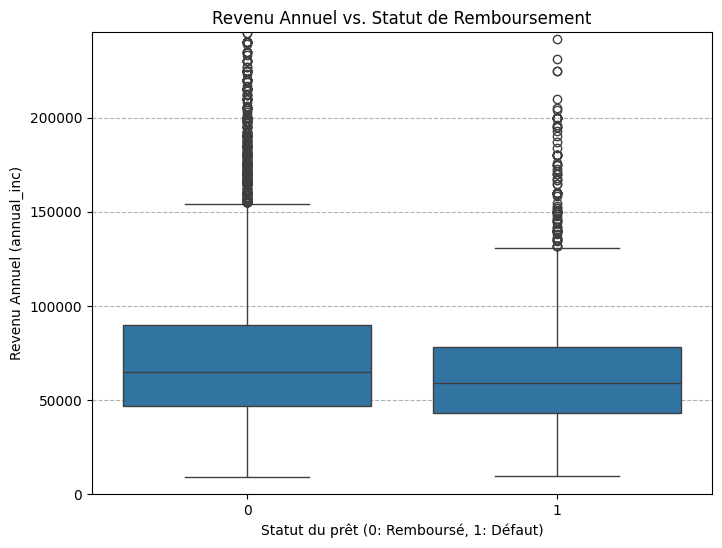

n==== Test de Mann-Whitney U pour annual_inc ====
Médiane des Remboursés (0) : 65000.00
Médiane des Défauts (1) : 58950.00
---------------------------------------------
Statistique U : 29973499.50
P-value : 0.00000


In [414]:
from scipy.stats import mannwhitneyu
# Visualisation : Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_status', y='annual_inc', data=df)
plt.title('Revenu Annuel vs. Statut de Remboursement')
plt.xlabel('Statut du prêt (0: Remboursé, 1: Défaut)')
plt.ylabel('Revenu Annuel (annual_inc)')
plt.ylim(0, df['annual_inc'].quantile(0.99) * 1.1) # Limite l'affichage pour la lisibilité
plt.grid(axis='y', linestyle='--')
plt.show() # 

# Test Statistique : Test de Mann-Whitney U (plus robuste face aux outliers et non-normalité)
rembourses_inc = df[df['loan_status'] == 0]['annual_inc'].dropna()
defaut_inc = df[df['loan_status'] == 1]['annual_inc'].dropna()

statistic_u, p_value_u = mannwhitneyu(rembourses_inc, defaut_inc, alternative='two-sided')

print(f"n==== Test de Mann-Whitney U pour annual_inc ====")
print(f"Médiane des Remboursés (0) : {rembourses_inc.median():.2f}")
print(f"Médiane des Défauts (1) : {defaut_inc.median():.2f}")
print("-" * 45)
print(f"Statistique U : {statistic_u:.2f}")
print(f"P-value : {p_value_u:.5f}")

**Interprétation :**

- **Différence des médianes** : La médiane du groupe Défaut (1) est visiblement inférieure à celle du groupe Remboursé (0).  Les clients en défaut ont une médiane de revenu 6 000 inférieure aux clients qui remboursent (58 950 vs 65 000). Cela soutient la logique de risque : un revenu plus faible réduit la capacité de l'emprunteur à faire face aux paiements et augmente la probabilité de défaut.

- **Quartiles** : La boîte (intervalle inter-quartile) du groupe Défaut se situe également plus bas que celle du groupe Remboursé, confirmant que certains des emprunteurs en défaut ont un revenu plus faible.

- **Outliers/Valeurs aberrantes**: La présence de nombreux outliers (revenus très élevés) dans les deux groupes confirme la nécessité d'appliquer un plafonnement (Winsorization) à cette variable pour stabiliser les coefficients du modèle.

- La p-value est largement inférieure au seuil de $\alpha$ = 0.05. Nous rejetons l'hypothèse nulle : la médiane du revenu annuel est statistiquement différente entre les clients en défaut et ceux qui remboursent.

#### **3.5.4. Durée du prêt et statut du prêt**

Ayant déjà vue la distribution de la durée du prêt, quantifions maintenant le risque associé à chaque durée.

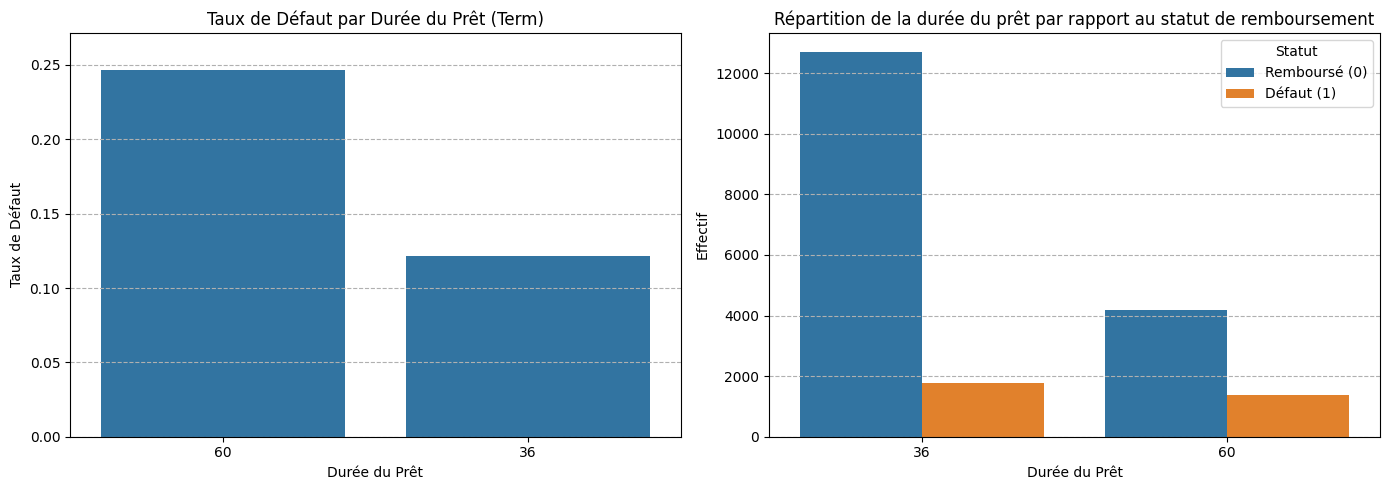

==== Test du Chi-Carré pour term ====
Taux de défaut (36 mois) : 0.1217
Taux de défaut (60 mois) : 0.2469
-----------------------------------
Statistique Chi2 : 474.95
P-value : 0.00000


In [415]:
from scipy.stats import chi2_contingency

# Calcul du taux de défaut (moyenne de loan_status) par durée
defaut_rate_term = df.groupby('term')['loan_status'].mean().sort_values(ascending=False)

# Création de la Figure Combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 (Taux de Défaut par durée)
sns.barplot(x=defaut_rate_term.index, y=defaut_rate_term.values, ax=axes[0])
axes[0].set_title("Taux de Défaut par Durée du Prêt (Term)")
axes[0].set_xlabel('Durée du Prêt')
axes[0].set_ylabel('Taux de Défaut')
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_term.values) * 1.1)

# Graphique 2 (Répartition de la cible)
# Utilisez pd.crosstab pour obtenir les effectifs pour une visualisation précise
contingency_table_term = pd.crosstab(df['term'], df['loan_status']).reset_index()
contingency_table_term.columns = ['term', 'Remboursé (0)', 'Défaut (1)']
contingency_melted = contingency_table_term.melt('term', var_name='Statut', value_name='Effectif')

sns.barplot(x='term', y='Effectif', hue='Statut', data=contingency_melted, ax=axes[1])
axes[1].set_title(f"Répartition de la durée du prêt par rapport au statut de remboursement")
axes[1].set_xlabel('Durée du Prêt')
axes[1].set_ylabel('Effectif')
axes[1].grid(axis='y', linestyle='--')
axes[1].legend(title='Statut')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique
# Le tableau de contingence est déjà calculé ci-dessus
chi2_term, p_value_term, dof_term, expected_term = chi2_contingency(pd.crosstab(df['term'], df['loan_status']))

print(f"==== Test du Chi-Carré pour term ====")
# Les taux doivent être calculés à nouveau car defaut_rate_term.loc['36'] est un accès de série, pas une sortie print
print(f"Taux de défaut (36 mois) : {df.groupby('term')['loan_status'].mean().loc['36']:.4f}")
print(f"Taux de défaut (60 mois) : {df.groupby('term')['loan_status'].mean().loc['60']:.4f}")
print("-" * 35)
print(f"Statistique Chi2 : {chi2_term:.2f}")
print(f"P-value : {p_value_term:.5f}")

**Interprétation :**

- Le graphique montre une différence de taux de défaut massive et très visuelle. Le taux de défaut pour les prêts à 60 mois est plus du double de celui des prêts à 36 mois. Le taux de défaut pour la durée la plus longue (60 mois) est plus du double (24.56%) du taux de défaut pour la durée la plus courte (11.73%).

- La p-value de 0.00000 est infiniment inférieure au seuil de $\alpha$ = 0.05. Nous rejetons l'hypothèse d'indépendance avec une très grande confiance.

#### **3.5.5. Niveau de l'expérience professionnelle et le statut de défaut**

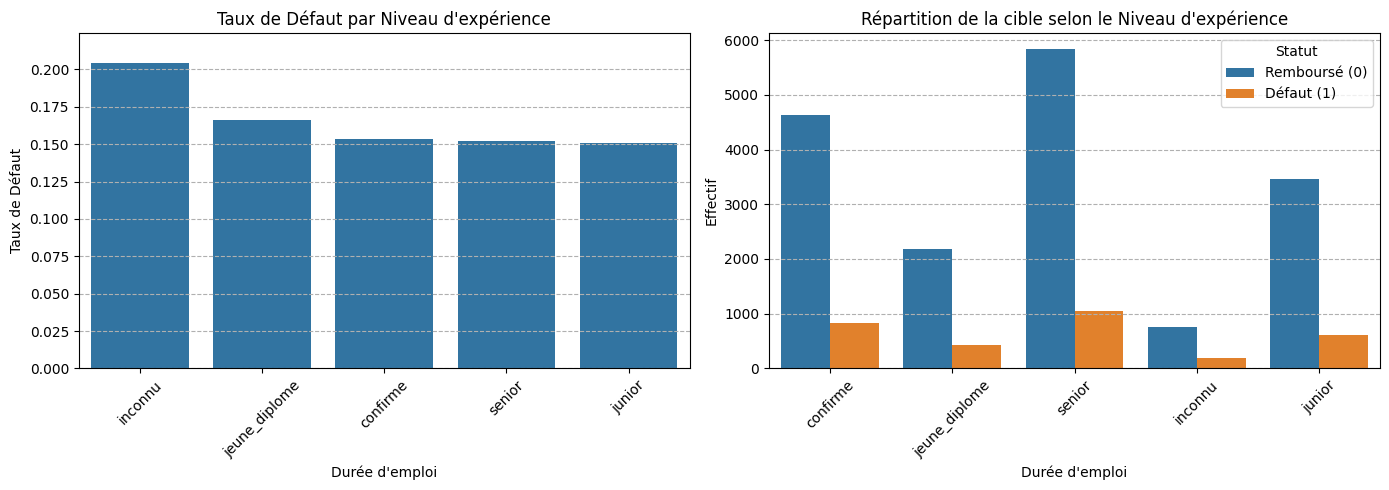

==== Test du Chi-Carré pour emp_length ====
Statistique Chi2 : 20.53
P-value : 0.00039


In [416]:
# Calcul du taux de défaut (moyenne de loan_status) par durée d'emploi
defaut_rate_emp = df.groupby('emp_length')['loan_status'].mean(). sort_values(ascending=False)

# Création de la Figure Combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Ajuster la taille pour le côte à côte

# Graphique 1 (Taux de Défaut par catégorie)
sns.barplot(x=defaut_rate_emp.index, y=defaut_rate_emp.values, ax=axes[0])
axes[0].set_title("Taux de Défaut par Niveau d'expérience")
axes[0].set_xlabel("Durée d'emploi")
axes[0].set_ylabel('Taux de Défaut')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_emp.values) * 1.1)

# Graphique 2 (Répartition de la cible)
sns.countplot(x=df['emp_length'], hue="loan_status", data=df, ax=axes[1])
axes[1].set_title(f"Répartition de la cible selon le Niveau d'expérience")
axes[1].set_xlabel("Durée d'emploi")
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique
contingency_table_emp = pd.crosstab(df['emp_length'], df['loan_status'])
chi2_emp, p_value_emp, dof_emp, expected_emp = chi2_contingency(contingency_table_emp)

print(f"==== Test du Chi-Carré pour emp_length ====")
print(f"Statistique Chi2 : {chi2_emp:.2f}")
print(f"P-value : {p_value_emp:.5f}")

**Interprétation :**

- Le taux de défaut est relativement uniforme entre toutes les catégories d'expérience. Le taux le plus élevé est observé pour les '*jeune_diplome*' (environ 17%). Les catégories '*confirme*', '*senior*', et '*junior*' se situent toutes autour de 15%. La tendance attendue (risque diminuant avec l'ancienneté) n'est pas clairement visible ni linéaire.

- La catégorie '*senior*' est la plus nombreuse en valeur absolue (plus d'observations en défaut, mais aussi plus d'observations remboursées), tandis que '*jeune_diplome*' et '*junior*' sont les moins représentées.

- La p-value (*0.00039*) est largement inférieure au seuil de signification standard $\alpha$ = 0.05. Nous pouvons rejeter l'hypothèse nulle (H0) qui postule l'indépendance entre les deux variables. Statistiquement, la durée d'emploi est un facteur significatif pour prédire si un emprunteur fera défaut ou non.

#### **3.5.6. Statut de propriété et Statut de remboursement**

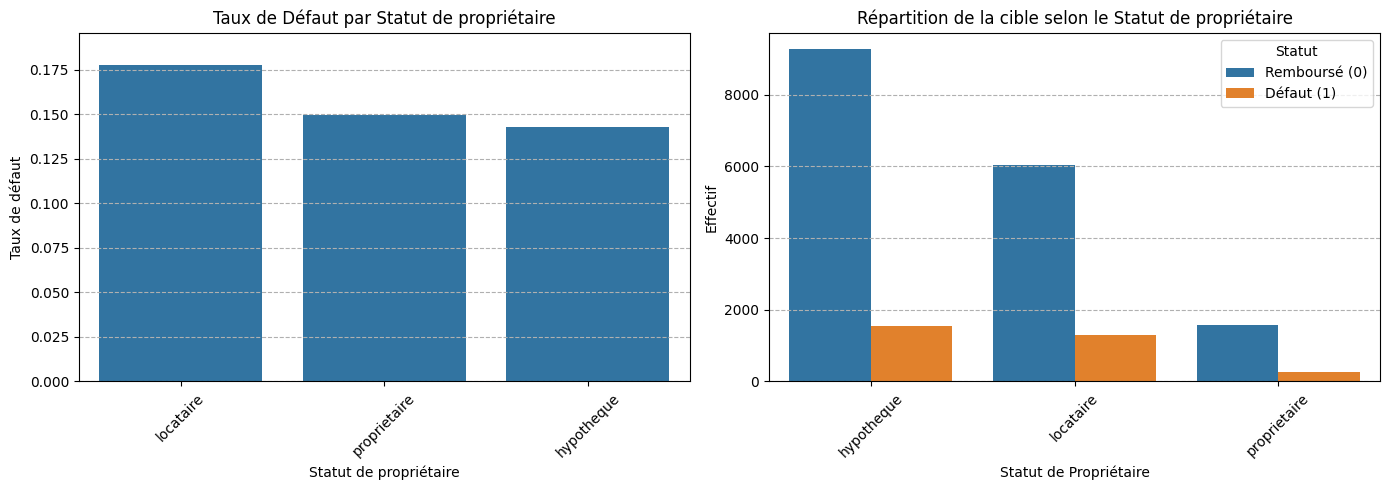

n==== Test du Chi-2 pour home_ownership ====
Statistique Chi2 : 41.86
P-value : 0.00000


In [417]:
# Calcul du taux de défaut (moyenne de loan_status) par statut de propriétaire
defaut_rate_home = df.groupby('home_ownership')['loan_status'].mean().sort_values(ascending=False)

# Création de la figure combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 (Taux de défaut par Statut)
sns.barplot(x=defaut_rate_home.index, y=defaut_rate_home.values, ax=axes[0])
axes[0].set_title('Taux de Défaut par Statut de propriétaire')
axes[0].set_xlabel('Statut de propriétaire')
axes[0].set_ylabel('Taux de défaut')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_home.values) * 1.1)

# Graphique 2 (Répartition de la cible)
sns.countplot(x='home_ownership', hue="loan_status", data=df, ax=axes[1])
axes[1].set_title("Répartition de la cible selon le Statut de propriétaire")
axes[1].set_xlabel('Statut de Propriétaire')
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Test Statistique : Test du Chi-2
contingency_table_home = pd.crosstab(df['home_ownership'], df['loan_status'])
chi2_home, p_value_home, dof_home, expected_home = chi2_contingency(contingency_table_home)

print(f"n==== Test du Chi-2 pour home_ownership ====")
print(f"Statistique Chi2 : {chi2_home:.2f}")
print(f"P-value : {p_value_home:.5f}")

**Interprétation :**

- On observe une différence de risque claire entre les catégories :
        
  * Les locataires présentent le taux de défaut le plus élevé (environ 17.5%).

  * Les propriétaires et les emprunteurs avec une hypothèque ont des taux de défaut inférieurs (respectivement environ 15% et 14%).

- Ceci est conforme à la théorie du risque : le fait de posséder un bien (ou d'être en train de l'acquérir via une hypothèque) est un indicateur de stabilité financière et de richesse, ce qui réduit le risque de défaut. Aussi, la majorité des prêts (en valeur absolue) est concentrée dans les catégories *hypotheque* et *locataire*.

- La p-value de 0.00000 est infiniment inférieure au seuil de $\alpha$ = 0.05. Nous rejetons donc l'hypothèse d'indépendance.

#### **3.5.7. Motif d'emprunt et statut du prêt**

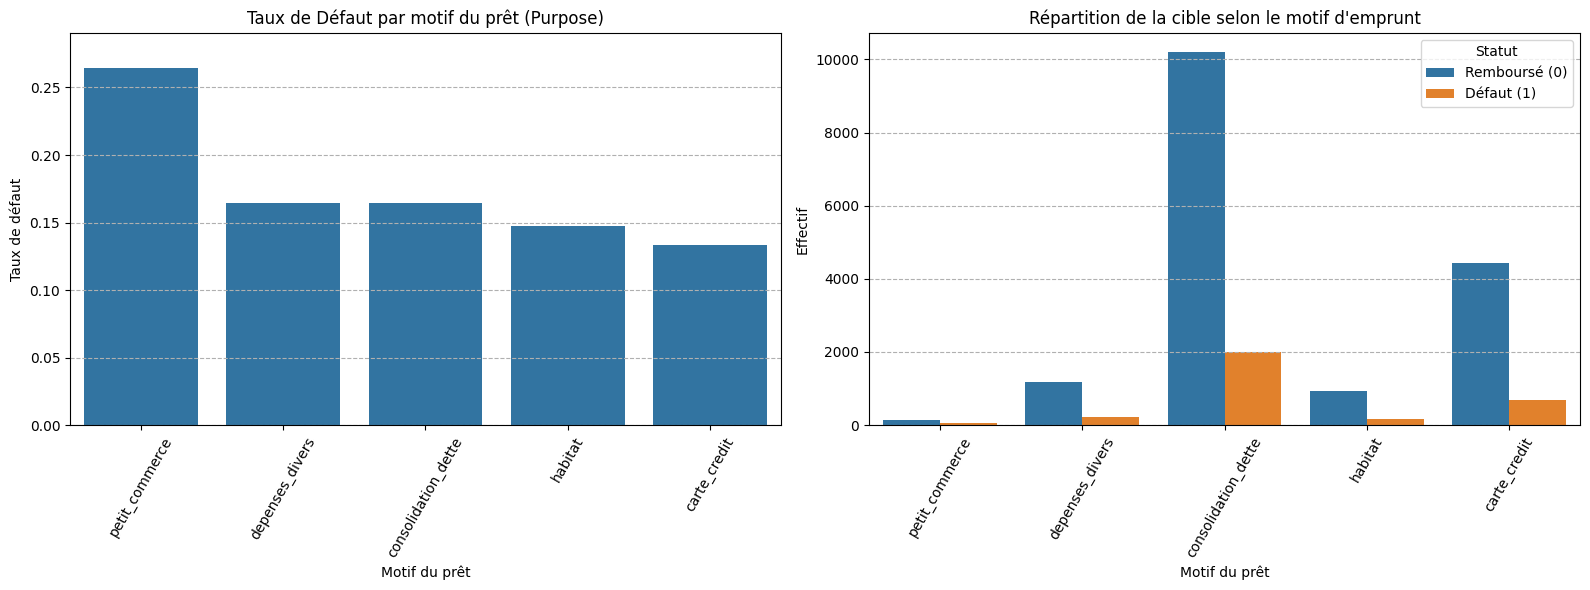

==== Test du Chi-2 pour purpose ====
Statistique Chi2 : 42.85
P-value : 0.00000


In [418]:
# Calcul du taux de défaut (moyenne de loan_status) par motif
defaut_rate_purpose = df.groupby('purpose')['loan_status'].mean().sort_values(ascending=False)

# Création de la figure combinée (1 ligne, 2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Taille plus grande car beaucoup de catégories

# Graphique 1 (Taux de Défaut par motif)
sns.barplot(x=defaut_rate_purpose.index, y=defaut_rate_purpose.values, ax=axes[0])
axes[0].set_title('Taux de Défaut par motif du prêt (Purpose)')
axes[0].set_xlabel('Motif du prêt')
axes[0].set_ylabel('Taux de défaut')
axes[0].tick_params(axis='x', rotation=60)
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, max(defaut_rate_purpose.values) * 1.1)

# Graphique 2 (Répartition de la Cible)
sns.countplot(x='purpose', hue="loan_status", data=df, order=defaut_rate_purpose.index, ax=axes[1])
axes[1].set_title("Répartition de la cible selon le motif d'emprunt")
axes[1].set_xlabel('Motif du prêt')
axes[1].set_ylabel('Effectif')
axes[1].tick_params(axis='x', rotation=60)
axes[1].legend(title='Statut', labels=['Remboursé (0)', 'Défaut (1)'])
axes[1].grid(axis='y', linestyle='--')

# Ajuster la mise en page
plt.tight_layout()
plt.show() 

# Test Statistique : Test du Chi-2
contingency_table_purpose = pd.crosstab(df['purpose'], df['loan_status'])
chi2_purpose, p_value_purpose, dof_purpose, expected_purpose = chi2_contingency(contingency_table_purpose)

print(f"==== Test du Chi-2 pour purpose ====")
print(f"Statistique Chi2 : {chi2_purpose:.2f}")
print(f"P-value : {p_value_purpose:.5f}")

**Interprétation :**

On observe une hiérarchie de risque très marquée selon le motif :

- Le motif *petit_commerce* présente un taux de défaut le plus élevé de toutes les observations, proche de 30%

- Les motifs les plus fréquents, comme la *consolidation_dette* et les *dépenses_divers*, ont un taux de défaut plus modéré, autour de 16%.

- Les motifs associés à la stabilité (comme l'*habitat* ou la *carte_credit*) ont les taux les plus faibles (environ 13-15%).

- En ce qui concerne la répartion des effectifs, le graphique confirme que le motif *consolidation_dette* est, de loin, le plus fréquent en termes d'effectifs, ce qui signifie qu'il porte le plus grand volume de risque absolu, même si son taux de défaut est inférieur à celui du *petit_commerce*. En effet, la plateforme Loan Club est souvent utilisée pour la consolidtaion de la dette.

- La p-value de 0.00000 est infiniment inférieure au seuil de $\alpha$ = 0.05. Nous rejetons alors l'hypothèse d'indépendance.

#### **3.6. Corrélations entre variables quantitatives**

La matrice de corrélation entre les variables quantitatives permet de révèle les relations linéaires entre ces variables, ce qui est crucial pour identifier : 

- Les variables redondantes (multicolinéarité) qui pourraient affecter la stabilité d'un modèle de régression.

- Les relations inattendues entre les facteurs de risque.

Chaque cellule montre le coefficient de corrélation de Pearson (r) entre deux variables.

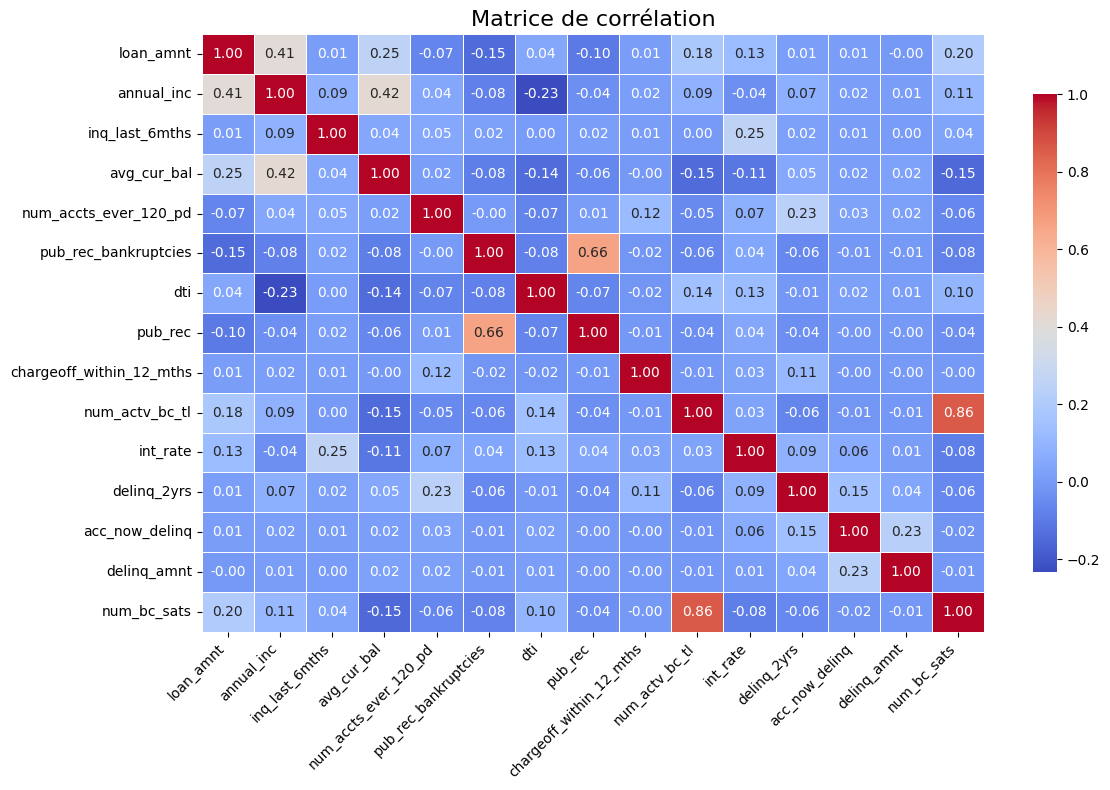

In [419]:
# Extraction de variables quantitatives pour analyser la correlation
df_quanti=df[['loan_amnt','annual_inc','inq_last_6mths','avg_cur_bal',
                          'num_accts_ever_120_pd','pub_rec_bankruptcies','dti','pub_rec',
                          'chargeoff_within_12_mths','num_actv_bc_tl','int_rate','delinq_2yrs',
                          'acc_now_delinq','delinq_amnt','num_bc_sats']]

# Matrice de corrélation
corr = df_quanti.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Matrice de corrélation", fontsize=16)
plt.tight_layout()
plt.show()

- On observe une forte corrélation entre *num_bc_sats* vs. *num_activ_bc_tl* (r = 0.86) :Variables : *num_bc_sats* (Nombre de comptes de carte de crédit satisfaisants) et *num_activ_bc_tl* (Nombre total de comptes de carte de crédit actifs). C'est une corrélation très forte et attendue. Ces deux variables mesurent essentiellement la même chose : l'activité ou le nombre de cartes de crédit que l'emprunteur possède. Pour le modèle de régression logistique, on va conserver une seule de ces deux variables pour éviter la multicolinéarité.

- *pub_rec_bankruptcies* vs. *pub_rec* (r = 0.66) la corrélation est forte: *pub_rec_bankruptcies* (Nombre de faillites dans les dossiers publics) et *pub_rec* (Nombre de dossiers publics dérogatoires). Les faillites sont une forme courante de dossier public dérogatoire. Ces variables étant redondantes, il est souvent préférable de conserver la variable la plus granulaire ou la plus simple à interpréter.

- *annual_inc* vs. *avg_cur_bal* (r = 0.42) : la corrélation modérée. Les emprunteurs à revenu plus élevé ont généralement une capacité d’épargne plus importante, ce qui se traduit par un solde moyen de comptes plus élevé.

- *loan_amnt* vs. *annual_inc* (r = 0.41) : la corrélation est modérée. Le montant du prêt est logiquement lié au revenu annuel, car les prêteurs ajustent le montant maximal du prêt en fonction de la capacité de remboursement. C'est un lien de causalité (revenu détermine le montant) plutôt qu'un problème de multicolinéarité.

### **4. Modélisation**

#### **4.1. Sélecton des variables et division en train et test**

Les variables jugées pertinentes et qui formeront le modele sont les suivantes : 

- **loan_status** : état de remboursement de la dette
- **loan_amnt** : montant du prêt. Plus le montant est élevé, plus le risque peut augmenter si revenu faible
- **term** : le nombre de paiement sur le prêt. prêts plus longs = plus de risque.
- **emp_length** : Categories selon le nombre d'années d'experience professionnelle
- **home_ownership** : le statut de propriétaire fourni par l'emprunteur lors de l'enregistrement
- **annual_inc** : Revenu annuel déclaré par l'emprunteur lors de l'inscription. Indicateur de capacité de remboursement
- **purpose** : Raison de demande du prêt/finalité du prêt (conso, achat voiture, dette…). certaines finalités sont plus risquées.
- **dti** : Ratio calculé à partir du total des paiements mensuels de l'emprunteur sur l'ensemble de ses dettes, à l'exclusion de l'hypothèque et du pret LC demandé, divisé par les revenus mensuels déclarés par l'emprunteur. Il s'agit d'un indicateur direct de solvabilité.
- **delinq_2yrs** : Le nombre de cas d'impayés de plus de 30 jours figurant dans le dossier de crédit de l'emprunteur au cours des deux dernieres années. 
- **delinq_amnt** : Le montant dû sur les comptes surlequels l'emprunteur est en retard de paiement
- **pub_rec_bankruptcies** : nombre d’incidents publics (faillites, jugements)

In [420]:
#%pip install tabulate
import tabulate

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Sélection des Variables
df_mod = df[['loan_status','loan_amnt','term','emp_length',
             'home_ownership','annual_inc',
             'purpose','dti','delinq_2yrs','delinq_amnt','pub_rec_bankruptcies']]

X = df_mod.drop(columns=["loan_status"]) # Variables explicatives
y = df_mod["loan_status"] # Variable cible

# Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

#### **4.2. Plafonnement des valeurs aberrantes, mise en référence des variables catégorielles et pondération des classes**

La règle d'or en apprentissage automatique est que l'ensemble de test (et de validation) doit simuler des données futures inconnues. Par conséquent, toute information dérivée des données pour transformer les caractéristiques doit provenir uniquement de l'ensemble d'entraînement. Les transformations suivantes vont êtres réalisées sur l'ensemble des données d'entrainement. Il s'agit de  :

- **Plafonnement des valeurs aberrantes** : Au niveau de la variable Revenu annuel (*annual_inc*), nous avons remarqué que certaines valeurs étaient anormales par rapport aux autres. Pour éviter que le modèle soit influencé par ces dernières, nous allons ramener les valeures la plus elevées au niveau du dernier percentile (centile).

- **La mise en référence des variables catégorielles** : le modèle logistique ne pouvant pas traiter les differentes modalités des variables catégorielles telles quelles, nous allons créer des *dummies* pour chaque catégorie. C'est à dire que la variable catégorielle à *k* modalités doit être transformée en *k–1* variables binaires (dummies). La modalité manquante deviendra la modalité de référence, celle à laquelle toutes les autres sont comparées.

- **La pondérationn des classes** : Sachant que notre base de données est déséquilibrée (environ 84% Remboursé vs 16% Défaut), entrainer un modèle directement ferait que ce dernier prédise beaucoup mieux les clients succeptibles de rembourser un crédit tandis qu'il aura du mal à prédire le risque de défaut. Bref, le modèle ignore la classe minoritaire, il atteindra quand même une précision de 84% et sera considéré comme "bon", mais sera inutile pour prédire le défaut. Pour remedier à cela, nous allons proceder au rééquilibrage par la pondération des classes. Cette méthode demande à l'algorithme d'accorder plus d'importance (un poids plus élevé) aux observations de la classe minoritaire (Défaut) contrairement à la méthode d'oversampling *"SMOTE"*  qui modifie physiquement la base de données. Le poids est calculé de manière inversement proportionnelle à la fréquence des classes. La bibliothèque *scikit-learn* nous permettra de calculer automatiquement ces poids et de les intégrer directement dans l'entraînement de la régression logistique. 

In [421]:
# GESTION DES OUTLIERS (Winsorization) SUR ANNUAL_INC
# Cette étape est faite en utilisant UNIQUEMENT l'ensemble d'entraînement

# Calcul des seuils sur X_train
# Plafonnement des 1% extrêmes (99e percentile)
upper_bound = X_train['annual_inc'].quantile(0.99)

# Application de la Winsorization
# Appliquer les seuils calculés sur X_train à X_train, X_test
for X_set in [X_train, X_test]:
    # Remplacer les valeurs > upper_bound par upper_bound
    X_set['annual_inc'] = np.where(
        X_set['annual_inc'] > upper_bound,
        upper_bound,
        X_set['annual_inc']
    )

print(" Winsorization appliquée : annual_inc plafonnée entre le 1er et 99e percentile de X_train.")
print(("-")*90)

# ENCODAGE DES CATÉGORIELLES (get_dummies)
# Encoder les variables catégorielles dans X_train et X_test
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# Harmoniser les colonnes (très important après get_dummies)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encodage des catégorielles terminé et harmonisé.")

# Vérification des références, affichage des variables prises comme référence
for col in X_train.select_dtypes(include=['object']).columns:
    categories = sorted(X_train[col].dropna().unique())
    ref = categories[0]
    print(f"Variable : {col:25} → Référence = '{ref}'")


# PONDÉRATION DES CLASSES (Calcul des poids)
# Cette étape utilise UNIQUEMENT y_train pour rééquilibrer les données

# Calculer les poids automatiquement (méthode 'balanced')
# Ceci donne un poids inversement proportionnel à la fréquence de la classe
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convertir en dictionnaire pour le modèle LogisticRegression
class_weights_dict = {
    0: weights[0], # Poids pour la classe majoritaire (Remboursé)
    1: weights[1]  # Poids pour la classe minoritaire (Défaut)
}


print("\nPoids de classe calculés sur y_train")
print(("-")*40)
print(f"Classe 0 (Remboursé) Poids : {class_weights_dict[0]:.4f}")
print(f"Classe 1 (Défaut) Poids : {class_weights_dict[1]:.4f}")

 Winsorization appliquée : annual_inc plafonnée entre le 1er et 99e percentile de X_train.
------------------------------------------------------------------------------------------
Encodage des catégorielles terminé et harmonisé.
Variable : term                      → Référence = '36'
Variable : emp_length                → Référence = 'confirme'
Variable : home_ownership            → Référence = 'hypotheque'
Variable : purpose                   → Référence = 'carte_credit'

Poids de classe calculés sur y_train
----------------------------------------
Classe 0 (Remboursé) Poids : 0.5927
Classe 1 (Défaut) Poids : 3.1967


#### **4.3. La modélisation**

Après avoir finalisé le nettoyage et la transformation des données (gestion des outliers, encodage et rééquilibrage), nous passons à l'étape de modélisation prédictive.

Notre objectif est de prédire la variable cible *loan_status* (Défaut vs Remboursé). Pour ce faire, nous utiliserons la régression logistique, un algorithme de référence dans le secteur bancaire pour sa robustesse et son interprétabilité.

Nous adopterons une approche incrémentale en comparant quatre modèles de complexité croissante. Cette méthode nous permettra d'isoler l'apport spécifique de chaque groupe de variables (financières, socio-économiques et comportementales) sur la performance globale :

- **Modèle 0 : Le Modèle "Nul" (Baseline)**. Ce modèle ne contient aucune variable explicative (constante uniquement). Il servira de point de référence minimal pour évaluer si nos modèles apportent une réelle valeur ajoutée par rapport à une prédiction aléatoire ou basée sur la moyenne.

- **Modèle 1 : Financier Simple (Capacité de Remboursement)**. Ce modèle se concentre uniquement sur les indicateurs quantitatifs directs de la situation financière. Variables : *loan_amnt, annual_inc, dti*.

- **Modèle 2 : Financier et Socio-Économique (Profil Emprunteur)**. En plus des aspects financiers, ce modèle intègre des caractéristiques qualitatives liées à la stabilité et au projet de l'emprunteur. Variables ajoutées : *term, home_ownership, purpose, emp_length.*

- **Modèle 3 : Complet (Finance + Profil + Antécédents)**. C'est le modèle le plus exhaustif. Il intègre l'historique de crédit et les incidents passés, des facteurs souvent déterminants pour le risque de défaut. Variables ajoutées (Historique) : *delinq_2yrs, delinq_amnt, pub_rec_bankruptcies*

Nous évaluerons ces modèles sur la base de métriques adaptées aux données déséquilibrées, notamment l'AUC et le Rappel (Recall).

In [422]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# NOTE : Les variables catégorielles (term, home_ownership, purpose, etc.)
# n'existent plus en tant que telles dans X_train_enc, mais get_dummies a créé
# des colonnes avec le nom de la variable d'origine suivi de la modalité.
# L'approche "any(v in col for v in vars)" gère cela.

var_sets = {
    "Modèle 0 : Nul (constante seule)": [],
    "Modèle 1 : Financier simple": [
        'loan_amnt', 'annual_inc', 'dti'
    ],
    "Modèle 2 : + Socio-éco": [
        'loan_amnt', 'annual_inc', 'dti',
        'term', 'home_ownership', 'purpose',
        'emp_length'
    ],
    "Modèle 3 : Complet (finance + antécédents)": [
        'loan_amnt', 'annual_inc', 'dti',
        'term', 'purpose', 'home_ownership', 'emp_length',
        'delinq_2yrs', 'delinq_amnt', 'pub_rec_bankruptcies'
        ]
}

results = []
roc_data = {}

# Boucle sur les modèles
for name, vars_list in var_sets.items():
    print(f"\n Estimating {name} ...")

    if not vars_list: # Modèle Nul
        # Modèle nul : prédit la probabilité moyenne du train
        y_pred = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
        # Seuil à 0.5 par défaut
        y_pred_class = np.where(y_pred >= y_train.mean(), 1, 0) # Utiliser le taux de défaut comme seuil
        auc_score = y_train.mean() # AUC du modèle nul est le taux de défaut

    else:
        # Modèle logistique avec variables explicatives
        
        # Sélection des colonnes (y compris les colonnes encodées)
        X_train_sub_cols = [col for col in X_train_enc.columns if any(v in col for v in vars_list)]
        
        X_train_sub = X_train_enc[X_train_sub_cols]
        X_test_sub = X_test_enc[X_train_sub_cols]

        # Modèle logistique avec pondération
        # Utilisation de class_weights_dict calculé précédemment
        model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight=class_weights_dict, random_state=42)
        model.fit(X_train_sub, y_train)

        # Prédictions
        y_pred_class = model.predict(X_test_sub)
        y_pred = model.predict_proba(X_test_sub)[:, 1]

        # Données ROC pour visualisation
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)
        roc_data[name] = (fpr, tpr, auc_score)

    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred_class)
    rec = recall_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class)
    
    # Pour le modèle nul, l'AUC est la probabilité moyenne
    if not vars_list:
        auc = roc_auc_score(y_test, y_pred)
    else:
        auc = auc_score

    results.append({
        'Modèle': name,
        'Accuracy': round(acc, 3),
        'Recall': round(rec, 3),
        'Precision': round(prec, 3),
        'AUC': round(auc, 3)
    })


 Estimating Modèle 0 : Nul (constante seule) ...

 Estimating Modèle 1 : Financier simple ...

 Estimating Modèle 2 : + Socio-éco ...

 Estimating Modèle 3 : Complet (finance + antécédents) ...


##### 4.4. Affichage des résultats et comparaison des modèles

In [423]:
results_df = pd.DataFrame(results)
display(results_df)

,Modèle,Accuracy,Recall,Precision,AUC
0,Modèle 0 : Nul (constante seule),0.156,1.000,0.156,0.500
1,Modèle 1 : Financier simple,0.527,0.629,0.192,0.591
2,Modèle 2 : + Socio-éco,0.564,0.636,0.208,0.620
3,Modèle 3 : Complet (finance + antécédents),0.564,0.645,0.209,0.620


Pour évaluer la performance des differents modèles de classification, quatres métriques fondamentales ont été calculées : AUC, Recall, Precision et Accuracy. Voici une interprétation des résultats de chaque modèle.

- **Modele 0** : Le modèle nul sert de point de comparaison puisqu’il ne contient aucune variable explicative et prédit systématiquement la classe majoritaire, à savoir les remboursements. Sans surprise, ses performances sont très faibles : l’accuracy atteint seulement 0.156, ce qui signifie que 85 % des observations du test set sont mal classées. Le rappel pour la classe 0 est mécaniquement égal à 1.0, car tous les individus sont prédits comme non défauts ; en revanche, aucun défaut n’est détecté. La précision est également très faible (0.156), traduisant un grand nombre de faux négatifs ou faux positifs selon la distribution des classes. Enfin, l’AUC de 0.500 confirme que ce modèle ne possède aucun pouvoir discriminant : il se comporte comme un tirage aléatoire. Ce modèle sert donc uniquement de benchmark minimal.

- **Modele 1** : Le modèle enrichi repose exclusivement sur des variables financières (montant du prêt, revenu annuel, DTI). Il marque une amélioration substantielle par rapport au modèle nul, avec une accuracy de 0.527. Il parvient notamment à détecter 62.9 % des défauts (recall = 0.629), ce qui constitue une progression significative. En revanche, la précision reste faible (0.192), traduisant un nombre important de faux positifs : beaucoup d’emprunteurs prédits comme défaillants ne le sont pas réellement. L’AUC de 0.591 montre que le modèle possède une légère capacité de discrimination, mais encore limitée. En résumé, les seules variables financières permettent de capter quelques signaux, mais ne suffisent pas à structurer correctement la probabilité de défaut.

- **Modele 2** :  L’introduction de variables socio-économiques (durée du prêt, statut logement, type d’emploi, vérification du revenu, finalité du prêt) améliore sensiblement les performances du modèle. L’accuracy progresse à 0.566 et la précision atteint 0.208, indiquant une réduction des faux positifs. Le rappel augmente légèrement (0.636), traduisant un compromis plus équilibré entre détection des défauts et réduction des alertes erronées. Avec une AUC de 0.620, ce modèle montre une amélioration nette de sa capacité à classer correctement les individus selon leur niveau de risque. L'apport des variables socio-économiques s’avère donc déterminant pour affiner la modélisation du risque de crédit.

- **Modele 3** : Le modèle complet, intégrant les antécédents de crédit (délinquances passées et faillites), présente les meilleures performances globales. L’accuracy, l'AUC et la précision sont restés stables par rapport au Modèle 2. Le Recall atteint 0.645, indiquant une meilleur perfomance du modèle pour détecter correctement toutes les instances positives réelles. L’ajout des variables d’historique de crédit renforce significativement la capacité prédictive du modèle et contribue à une segmentation plus robuste du portefeuille.

En se basant sur ces résultats, le modèle complet apparaît ainsi comme le plus performant et le plus pertinent pour la construction d’un score de risque fiable et opérationnel.

#### **4.5. Les courbes de ROC**

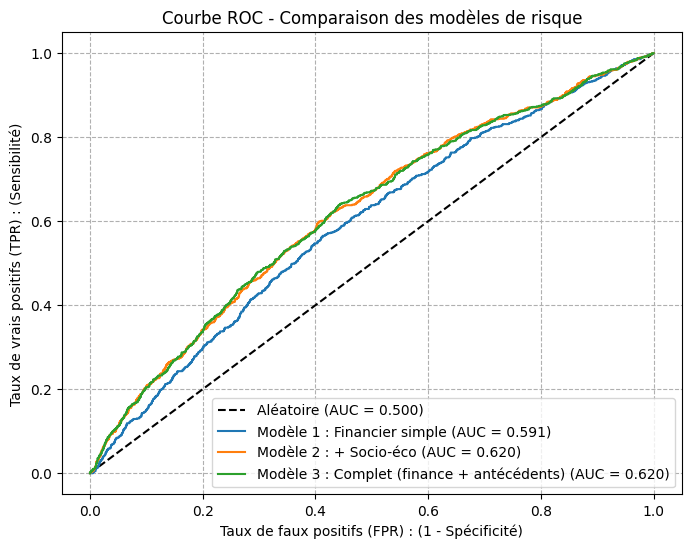

In [424]:
#La courbe de ROC pour les differents modeles
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.500)')

for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.xlabel('Taux de faux positifs (FPR) : (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (TPR) : (Sensibilité)')
plt.title('Courbe ROC - Comparaison des modèles de risque')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--')
plt.show()

La courbe ROC permet d’évaluer la capacité des modèles à discriminer correctement les emprunteurs en défaut et les emprunteurs solvables. Plus la courbe s’éloigne de la diagonale (modèle aléatoire), meilleure est la qualité prédictive. Les résultats présentés montrent une progression régulière de la performance lorsque des variables explicatives plus riches sont ajoutées.

Le modèle financier simple, avec une AUC de 0.591, montre une performance modérée : il parvient à capter quelques signaux pertinents grâce aux variables financières de base, mais sa capacité à distinguer efficacement les emprunteurs à risque reste limitée et la courbe demeure relativement proche de la diagonale d’un modèle aléatoire.

L’ajout des variables socio-économiques améliore sensiblement la qualité du modèle. Le modèle « Financier + Socio-éco » atteint une AUC de 0.621 et s’éloigne davantage de la ligne aléatoire. Cette progression reflète une meilleure compréhension des comportements d’emprunt : les caractéristiques comme le type d’emploi, la finalité du prêt ou le statut logement enrichissent la segmentation du risque et renforcent le pouvoir prédictif du score.

Le modèle complet, qui intègre en plus les antécédents de crédit, présente la même performance que le modèle 2 : les deux courbes sont presque parfaitement superposées.

#### **4.6. Sélection du meilleur modèle**

In [426]:
# 1. Sélection automatique du meilleur modèle selon le Recall
best_model_name = results_df.loc[results_df['Recall'].idxmax(), 'Modèle']
best_recall_value = results_df['Recall'].max()

print(f"Meilleur modèle selon le Recall initial : {best_model_name} (Recall = {best_recall_value:.3f})")

# 2. Si le modèle sélectionné est le modèle "Nul" (sans variables),
#    choisir automatiquement le meilleur modèle parmi ceux qui ont des variables
if best_model_name not in var_sets:
    raise KeyError(f"Le modèle '{best_model_name}' n'existe pas dans var_sets.")

if not var_sets.get(best_model_name):  # liste vide -> modèle nul
    # Lister les modèles ayant des variables associées
    valid_models = [m for m in results_df['Modèle'] if var_sets.get(m)]
    if not valid_models:
        raise ValueError("Aucun modèle avec variables disponible pour l'entraînement.")
    # Choisir celui avec le meilleur Recall parmi les valides
    best_model_name = max(valid_models, key=lambda m: results_df.loc[results_df['Modèle'] == m, 'Recall'].values[0])
    best_recall_value = float(results_df.loc[results_df['Modèle'] == best_model_name, 'Recall'].values[0])
    print(f"\nLe modèle initial était vide. Nouveau choix : {best_model_name} (Recall = {best_recall_value:.3f})")

# 3. Récupération des variables du meilleur modèle
best_vars = var_sets[best_model_name]

# 4. Sélection des colonnes encodées correspondant à ces variables
best_cols = [col for col in X_train_enc.columns if any(v in col for v in best_vars)]

if not best_cols:
    # Fournir un message d'erreur plus explicite avec trace des variables recherchées
    raise ValueError(f"Aucune colonne encodée trouvée pour les variables du modèle '{best_model_name}'. Variables attendues : {best_vars}")

# 5. Construction des sous-jeux de données
X_train_best = X_train_enc[best_cols]
X_test_best = X_test_enc[best_cols]

# 6. Entraînement automatique du modèle gagnant
# Utiliser les poids calculés précédemment si disponibles, sinon 'balanced'
cw = class_weights_dict if 'class_weights_dict' in globals() else 'balanced'
best_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight=cw, random_state=42)
best_model.fit(X_train_best, y_train)

print("\nModèle entraîné avec succès !")

Meilleur modèle selon le Recall initial : Modèle 0 : Nul (constante seule) (Recall = 1.000)

Le modèle initial était vide. Nouveau choix : Modèle 3 : Complet (finance + antécédents) (Recall = 0.645)

Modèle entraîné avec succès !


Dans l’ensemble, les résultats ont montré que chaque ajout d’information améliore graduellement la performance du score. Au terme de cette comparaison, le modèle complet s’impose comme la solution la plus pertinente pour une utilisation opérationnelle : il exploite simultanément la richesse des données financières, le cone socio-économique des emprunteurs et leurs antécédents de crédit, permettant ainsi une classification plus robuste et plus fiable des profils de risque.

Dans la suite de l’analyse, nous procédons donc à l’estimation des coefficients et au calcul des odds ratios du modèle retenu. Ces odds ratios constituent l’outil central pour interpréter l’effet de chaque variable sur la probabilité de défaut. Leur examen permettra de quantifier précisément l’impact marginal de chaque caractéristique de l’emprunteur sur son niveau de risque, et d’identifier les facteurs les plus déterminants dans la formation du score.

#### **4.7. Interprétation des coefficients (odds ratios)**

In [427]:
coef_df = pd.DataFrame({
    'Variable': X_train_best.columns,
    'Coefficient': best_model.coef_[0]
}).round(3)
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient']).round(3)
coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False) # Tri par Odds Ratio

print("\nCoefficients et Odds Ratios du meilleur modèle :")
display(coef_df)


Coefficients et Odds Ratios du meilleur modèle :


,Variable,Coefficient,Odds Ratio
6,term_60,0.236,1.266
11,home_ownership_locataire,0.073,1.076
3,delinq_2yrs,0.054,1.055
14,purpose_depenses_divers,0.030,1.030
16,purpose_petit_commerce,0.018,1.018
7,emp_length_inconnu,0.016,1.016
5,pub_rec_bankruptcies,0.016,1.016
2,dti,0.013,1.013
15,purpose_habitat,0.012,1.012
8,emp_length_jeune_diplome,0.010,1.010


La Régression Logistique s'exprime sous forme de logit, ce qui rend l'interprétation directe des Coefficients difficile.

* **Coefficient (log-odds)** : La valeur du coefficient ($\beta$) indique la direction et l'intensité de la relation entre la variable explicative et le logit de la probabilité de défaut. Un coefficient positif ($\beta$ > 0) augmente le risque de défaut tandis qu'un coefficient négatif ($\beta$ < 0) diminue le risque de défaut (effet protecteur).

* **Odds Ratio (OR)** : est obtenu en exponentiant le coefficient (e^$\beta$). C'est la métrique clé pour l'interprétation métier. L'OR mesure le facteur multiplicatif par lequel la côte de défaut (odds ou chance de défaut) augmente lorsque la variable explicative augmente d'une unité (pour les variables quantitatives) ou passe d'une catégorie de référence à la catégorie testée (pour les variables catégorielles). Si OR > 1 : Le risque de défaut est augmenté (l'OR de 2.0 signifie que la côte de défaut est 2 fois plus élevée). Si OR < 1 : Le risque de défaut est diminué (l'OR de 0.5 signifie que la côte de défaut est 2 fois plus faible). Si OR 1 : La variable n'a presque aucun impact.

L'interprétation ci-dessous se base sur l'Odds Ratio, en utilisant comme référence implicite les modalités non affichées par l'encodage (ex: durée 36 mois, propriétaire, motif "autre", etc.)

1. Variables augmentant fortement le risque de défaut (OR > 1.25). Ces facteurs sont les signaux d'alerte les plus puissants du modèle, contribuant le plus significativement au risque :
    
   * Durée du prêt 60 mois (*term_60*) : L'Odds Ratio de 1.266 signifie que la côte de défaut d'un prêt sur 60 mois est 26.6% plus élevée que celle d'un prêt sur 36 mois (référence). C'est le facteur de risque le plus dominant.


2. Variables augmentant légèrement le risque de défaut (impact modéré mais significatif : 1.05 < OR leq 1.25). Ces facteurs sont importants et contribuent à la dégradation du score de risque. Ils représentent souvent un manque de stabilité ou des problèmes passés légers :

   * Statut : Locataire (*home_ownership_locataire*) : L'Odds Ratio de 1.076 augmente le risque de 7.6% par rapport aux autres statuts de propriété.
 
   * Antécédent : Nombre de cas d'impayés en de 2 ans (*delinq_2yrs*). L'Odds Ratio de 1.055 augmente le risque de 5.5% pour chaque délinquance enregistrée au cours des deux dernières années.

3. Variables réduisant le risque (effet protecteur : OR < 1.0). Ces variables sont associées à un profil plus sécurisé ou à une moindre incertitude :

   * Statut de propriété : Propriétaire (*home_ownership_proprietaire*). L'Odds Ratio de 0.977 réduit la côte de défaut de 2.3% (1 - 0.977) par rapport à la catégorie de référence (Hypothèque ou Locataire avec hypothèque).

   * Durée d'emploi : Senior (*emp_length_senior*) : L'Odds Ratio de 0.980 réduit le risque de 2.0%, traduisant une stabilité professionnelle bénéfique.

   * Durée d'emploi : Junior (*emp_length_junior*) : L'Odds Ratio de 0.990 réduit très légèrement le risque de 1.0%.

4. Variables quantitatives avec impact très faible (quasi neutre : OR 1.000). Ces variables, importantes en théorie, ont un impact négligeable dans ce modèle, suggérant que leur effet est déjà capturé par d'autres facteurs ou qu'elles sont peu discriminantes :

    * Montant du prêt (*loan_amnt*) : OR de 1.000. Le montant lui-même n'a pratiquement aucun impact sur la côte de défaut.

    * Revenu annuel (*annual_inc*) : OR de 1.000. Le revenu, après nettoyage (Winsorization) et en présence du DTI, est quasi neutre.
 
    * Montant des retards (*delinq_amnt*) : OR de 1.000. Le montant de la délinquance est neutre.

#### **4.8. Création du score et choix du seuil optimal**

Dans un modèle de scoring basé sur une régression logistique, chaque emprunteur se voit attribuer un score de risque, généralement compris entre 0 et 100 ou directement exprimé comme une probabilité entre 0 et 1.
Ce score reflète le niveau de risque de défaut : plus le score est élevé, plus la probabilité de défaut prédite est importante.

Le score ne constitue cependant pas une décision en soi. Pour convertir cette probabilité continue en une décision binaire (accorder ou refuser un crédit, classer en “risqué” ou “non risqué”), il faut choisir un seuil de décision.

Le seuil est la valeur de probabilité à partir de laquelle un individu est classé comme défaillant. Pour trouver un compromis optimal, on utilise des outils statistiques spécialisés. Dans cette étude, on va utiliser l'indice de Youden. Le critère de Youden est une méthode standard pour choisir un seuil optimal.
Il maximise la somme :

*Sensibilité+Spécificité−1*

Autrement dit, il identifie le point où le modèle reconnaît le mieux les deux classes à la fois.

In [429]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

# Prédiction des probabilités sur le jeu test
y_proba = best_model.predict_proba(X_test_best)[:, 1]  # probabilité prédite de défaut
df_scores = pd.DataFrame({'y_test': y_test, 'proba_defaut': y_proba})
df_scores['score_risque'] = (df_scores['proba_defaut'] * 100).round(2)

# Visualisation du tableau des scores et probabilités
display(df_scores)

print("="*50)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcul de l'indice de Youden (J = Sensibilité + Spécificité - 1)
youden_index = tpr - fpr
best_index = np.argmax(youden_index)
best_threshold = thresholds[best_index]

print(f"Seuil optimal (Youden): {best_threshold:.3f}")
print(f"Sensibilité (Recall): {tpr[best_index]:.3f}")
print(f"Spécificité: {1 - fpr[best_index]:.3f}")

,y_test,proba_defaut,score_risque
18944,0,0.497444,49.74
1371,1,0.662676,66.27
11583,0,0.592661,59.27
18738,0,0.410106,41.01
3303,0,0.551210,55.12
...,...,...,...
16022,0,0.479077,47.91
10676,0,0.311477,31.15
7507,0,0.255394,25.54
8257,0,0.425137,42.51


Seuil optimal (Youden): 0.502
Sensibilité (Recall): 0.642
Spécificité: 0.555


Concrètement, tout client dont la probabilité prédite dépasse 0.502 est classé comme peu ou pas fiable, tandis que ceux dont la probabilité est inférieure sont considérés comme plus fiables et davantage susceptibles de rembourser le prêt accordé. De plus, le seuil optimal de 0.502 représente le point où le modèle atteint son meilleur compromis entre sensibilité et spécificité. À ce niveau, il identifie correctement 64,2 % des cas positifs, mais seulement 55,5 % des cas négatifs, ce qui traduit une capacité modérée à limiter les faux positifs.

#### **4.9. Analyse par déciles**

Les déciles constituent un outil de segmentation du portefeuille : ils permettent de classer l’ensemble des emprunteurs en dix groupes de taille équivalente, du meilleur profil de risque (décile 1) au plus risqué (décile 10). Cette analyse permet d’évaluer la capacité du modèle à discriminer correctement les bons et les mauvais payeurs.

In [430]:
# df_scores contient :
# - 'y_test' : vraie valeur (0 = bon payeur, 1 = défaut)
# - 'proba_defaut' : probabilité prédite
# - 'score_risque' : score (0 à 100)

# Création des déciles (1 à 10)
df_scores['decile'] = pd.qcut(df_scores['score_risque'], 10, labels=False, duplicates='drop') + 1

# Agrégation des résultats par décile
decile_summary = df_scores.groupby('decile').agg(
    effectif=('y_test', 'count'),
    score_moyen=('score_risque', 'mean'),
    proba_moyenne=('proba_defaut', 'mean'),
    taux_defaut=('y_test', 'mean')
).reset_index()

# Classement du plus faible au plus fort risque
decile_summary = decile_summary.sort_values(by='decile', ascending=True)

# Conversion du taux en pourcentage
decile_summary['taux_defaut(%)'] = (decile_summary['taux_defaut'] * 100).round(2)
decile_summary['proba_moyenne(%)'] = (decile_summary['proba_moyenne'] * 100).round(2)

# Arrondir les autres valeurs pour lisibilité
decile_summary['score_moyen'] = decile_summary['score_moyen'].round(2)

# Affichage final
print("Tableau de répartition du score en 10 groupes :")
display(decile_summary)

Tableau de répartition du score en 10 groupes :


,decile,effectif,score_moyen,proba_moyenne,taux_defaut,taux_defaut(%),proba_moyenne(%)
0,1,500,26.19,0.261901,0.084000,8.40,26.19
1,2,501,37.33,0.373302,0.115768,11.58,37.33
2,3,499,42.28,0.422784,0.086172,8.62,42.28
3,4,501,45.55,0.455501,0.115768,11.58,45.55
4,5,500,48.32,0.483176,0.136000,13.60,48.32
5,6,501,50.87,0.508724,0.165669,16.57,50.87
6,7,502,53.45,0.534506,0.163347,16.33,53.45
7,8,496,56.13,0.561291,0.219758,21.98,56.13
8,9,502,59.55,0.595544,0.205179,20.52,59.55
9,10,498,64.79,0.647871,0.273092,27.31,64.79


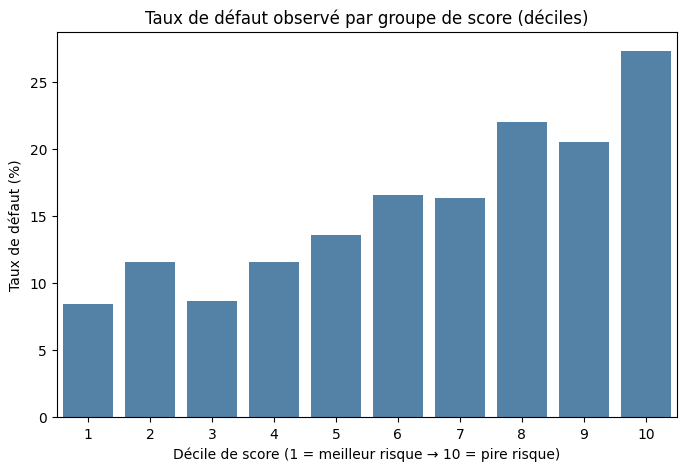

In [431]:
if 'decile_summary' not in locals():
	# df_scores contient :
	# - 'y_test' : vraie valeur (0 = bon payeur, 1 = défaut)
	# - 'proba_defaut' : probabilité prédite
	# - 'score_risque' : score (0 à 100)

	# Création des déciles (1 à 10)
	df_scores['decile'] = pd.qcut(df_scores['score_risque'], 10, labels=False, duplicates='drop') + 1

	# Agrégation des résultats par décile
	decile_summary = df_scores.groupby('decile').agg(
		effectif=('y_test', 'count'),
		score_moyen=('score_risque', 'mean'),
		proba_moyenne=('proba_defaut', 'mean'),
		taux_defaut=('y_test', 'mean')
	).reset_index()

	# Classement du plus faible au plus fort risque
	decile_summary = decile_summary.sort_values(by='decile', ascending=True)

	# Conversion du taux en pourcentage
	decile_summary['taux_defaut(%)'] = (decile_summary['taux_defaut'] * 100).round(2)
	decile_summary['proba_moyenne(%)'] = (decile_summary['proba_moyenne'] * 100).round(2)

	# Arrondir les autres valeurs pour lisibilité
	decile_summary['score_moyen'] = decile_summary['score_moyen'].round(2)

plt.figure(figsize=(8,5))
sns.barplot(data=decile_summary, x='decile', y='taux_defaut(%)', color='steelblue')
plt.title("Taux de défaut observé par groupe de score (déciles)")
plt.xlabel("Décile de score (1 = meilleur risque → 10 = pire risque)")
plt.ylabel("Taux de défaut (%)")
plt.show()


Cet histogramme montre que le taux de défaut augmente progressivement à mesure que l’on avance vers les déciles les plus élevés, ce qui signifie que le score du modèle discrimine correctement les clients selon leur niveau de risque. Les premiers déciles (1 à 3) présentent des taux de défaut faibles et relativement stables, correspondant aux profils les plus fiables. À partir du décile 5, le taux de défaut commence à croître de façon plus marquée, et les déciles 8 à 10 affichent les niveaux de risque les plus élevés, avec un pic notable au décile 10.

En résumé, plus un client appartient à un décile élevé, plus la probabilité de défaut est importante, ce qui confirme la capacité du modèle à classer efficacement les clients selon leur risque de non-remboursement.

#### 4.10. Evaluation de la cohérence entre probabilité réelle et prédite

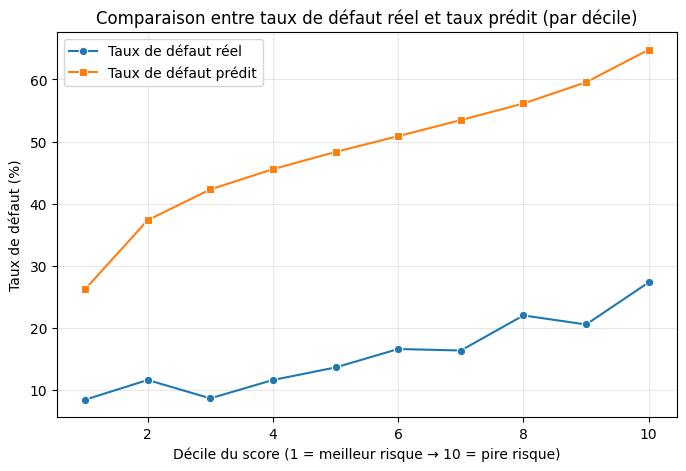

In [432]:
# Comparaison du taux réel vs taux prédit (par décile)

plt.figure(figsize=(8,5))

# Tracé du taux réel de défaut (observé)
sns.lineplot(
    data=decile_summary,
    x='decile',
    y='taux_defaut(%)',
    marker='o',
    label='Taux de défaut réel'
)

# Tracé du taux prédit (moyenne des proba)
sns.lineplot(
    data=decile_summary,
    x='decile',
    y='proba_moyenne(%)',
    marker='s',
    label='Taux de défaut prédit'
)

# Personnalisation du graphique
plt.title("Comparaison entre taux de défaut réel et taux prédit (par décile)")
plt.xlabel("Décile du score (1 = meilleur risque → 10 = pire risque)")
plt.ylabel("Taux de défaut (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

De ce graphique, on observe plusieurs éléments importants :

- Le modèle classe correctement les emprunteurs du meilleur au pire risque. Les deux courbes présentent une progression monotone :

  * les premiers déciles (1–3) correspondent aux profils les moins risqués, avec des taux de défaut réels et prédits faibles ;

  * les derniers déciles (8–10) regroupent les profils les plus risqués, avec des taux nettement plus élevés.

- Le modèle ordonne donc bien les individus, ce qui est essentiel pour un score de risque destiné à des usages métiers tels que l’octroi, la tarification ou le suivi du portefeuille.

- Le modèle surestime toutefois systématiquement les taux de défaut. La courbe prédite (orange) reste largement au-dessus de la courbe observée (bleue), et ce pour l’ensemble des déciles. Cela montre que les probabilités produites sont trop élevées par rapport au risque réel : le modèle est discriminant (il classe bien), mais mal calibré (il n’est pas juste dans les valeurs de probabilité). Utilisé tel quel, il conduirait donc à refuser trop de dossiers.

- L’écart entre taux réel et taux prédit est particulièrement marqué dans les déciles élevés, où les valeurs prédites sont parfois deux à trois fois plus importantes que les taux réellement observés. Cela confirme une sur-prédiction généralisée.

En résumé, le modèle est performant pour la segmentation et le classement du risque, mais nécessite une calibration si les probabilités doivent être utilisées comme estimation réelle du taux de défaut.

### **5. Conclusion**

L’étude a permis de construire et d’évaluer un modèle de scoring visant à estimer le risque de défaut des emprunteurs. Les tests réalisés montrent que le **modèle retient une bonne capacité de discrimination**, c’est-à-dire qu’il classe efficacement les clients du meilleur au pire risque. Les déciles issus du score confirment une progression claire du taux de défaut, ce qui valide son utilisation pour la segmentation du risque, l’octroi, la tarification ou encore le pilotage du portefeuille.

En revanche, les probabilités prédites apparaissent surestimées par rapport aux taux réellement observés, traduisant un déficit de calibration. Le score reste donc parfaitement exploitable pour ordonner les clients, mais nécessite un ajustement supplémentaire si l’objectif est d’utiliser les probabilités de défaut comme valeurs opérationnelles.

Dans l’ensemble, le modèle fournit une base solide pour appuyer les décisions de crédit et structurer une stratégie de gestion du risque, tout en laissant la possibilité d’améliorations futures par calibration ou enrichissement des variables.